# Chip Calibration Example
## Setup
## Find the qubit
1. One tone spectroscopy (VNA)
2. Punch out
3. Chevron Pattern
## Single qubit calibration
4. Amplitude Rabi Oscillation
5. Time Rabi Oscillation
6. Ramsey
7. Stack X90
8. Drag Alpha
9. Readout frequency optimization by blob separation
9. Single qubit randomized benchmarking
## Two qubits gate calibration (CR/CNOT)
10. Cross resonance scan
11. Full XY scan
12. CNOT truth table
13. Two qubits RB

# Setup

In [1]:
chip='X6Y3'
chip='X4Y1'
chip='X4Y2'
board='huracan'
board='pinto'
board='sian'
print(board,chip)

sian X4Y2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import time
from scipy.optimize import curve_fit,fminbound
import json

In [3]:
def rfswitch(board='huracan', chip='X6Y3'):
    import switchbox
    with open('swcfg.json') as jfile:
        swcfg=json.load(jfile)
    for sw,dest in swcfg['boardchip'][board][chip].items():
        switchbox.connect(url=swcfg['swurl'][sw],dest=dest)
    for sw in swcfg['swurl']:
        print(sw,switchbox.urlread(swcfg['swurl'][sw]))        
rfswitch(board,chip)

sw1 Connected ports: A-C, B-D
sw2 Connected ports: A-C, B-D
sw3 Connected ports: A-C, B-D


In [4]:
import json
import switchbox
with open('swcfg.json') as jfile:
    swcfg=json.load(jfile)
## 'AB' for sync test (Huracan Q0 drive to X4Y2, Sian Q0 drive to X6Y3) ##
## 'AC' for normal use (Huracan Q0 drive to X6Y3, Sian Q0 drive to X4Y2) ##
switchbox.connect(url=swcfg['swurl']['sw3'],dest='AC')
for sw in swcfg['swurl']:
    print(sw,switchbox.urlread(swcfg['swurl'][sw]))     

sw1 Connected ports: A-C, B-D
sw2 Connected ports: A-C, B-D
sw3 Connected ports: A-C, B-D


In [391]:
from distproc.hwconfig import FPGAConfig, load_channel_configs
import qubitconfig.qchip as qc
#reload(qc)
qchippath='chipcalibration/submodules/qchip/%s/%s/'%(chip,board)
qubic3serverport=dict(huracan=9096,pinto=9097,sian=9097)
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 
                            'jump_cond_clks': 5, 'jump_fproc_clks': 5, 
                            'pulse_regwrite_clks': 3, 'pulse_load_clks': 4})
channel_configs = load_channel_configs(qchippath+'channel_config.json')
qchip = qc.QChip(qchippath+'qubitcfg.json')

In [392]:
from distproc import asmparse

In [393]:
if 0:
    import qubic.run
    runner = qubic.run.CircuitRunner(commit='f24f1615')

In [394]:
if 1:
    import qubic.rpc_client as rc
    reload(rc)
    runner = rc.CircuitRunnerClient(ip='192.168.1.25', port=qubic3serverport[board]) #huracan
#runner = rc.CircuitRunnerClient(ip='192.168.1.25', port=9097) #pinto

In [395]:
import qubic.job_manager as jm
reload(jm)
jobman = jm.JobManager(fpga_config, channel_configs, runner, qchip)

In [396]:
import qubic.state_disc as sd
reload(sd)
gmm=sd.GMMManager(load_json=qchippath+'gmm.json')
#gmm = sd.GMMManager(qchippath+'Q01gmm.pkl')
jobman.update_gmm(gmm)

In [397]:
jobman.gmm_manager.savejson(qchippath+'gmm.json')

# One tone Spectroscopy (VNA)

In [ ]:
from chipcalibration import vna as vn
reload(vn)
fstart=6.5e9
fstop=6.9e9
#fstart=6.830e9
#fstop=6.846e9
#fstart=6000000.3e3
#fstop=6000000.9e3
vna = vn.Vna(0.04, np.linspace(fstart, fstop, 300), 200)
vna.run_and_report(jobman)

In [ ]:
%matplotlib inline
qchip = qc.QChip(qchippath+'qubitcfg.json')

plt.plot(vna.freqs, vna.results['amp'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (a.u.)')
plt.title('S11 Amplitude')
plt.show()
plt.plot(vna.freqs, np.unwrap(vna.results['phase']),'*-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')
plt.title('S11 Phase')
plt.show()

In [ ]:
for c in vna._circuits:
    for c1 in c:
        print(c1)

In [ ]:
asmparse.cmdparse(jobman.raw_asm_progs[0]['7']['cmd_buf'])

In [ ]:
%matplotlib inline
qchip = qc.QChip(qchippath+'qubitcfg.json')

plt.plot(vna.freqs, vna.results['amp'])
for i in range(8):
    x=qchip.qubits['Q%d'%i].readfreq
    plt.axvline(x=x,color='black',alpha=0.3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (a.u.)')
plt.title('S11 Amplitude')
plt.show()
plt.plot(vna.freqs, vna.results['phase'])
for i in range(8):
    x=qchip.qubits['Q%d'%i].readfreq
    plt.axvline(x=x,color='black',alpha=0.3)
plt.axvline(x=x,color='black',alpha=0.3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')
plt.title('S11 Phase')
plt.show()

# Punchout

In [12]:
from chipcalibration import punchout as po
reload(po)
qubits = ['Q%d'%i for i in range(8)]
qubits = ['Q1']
#qubit_dict = punchout.get_qubit_dict(qubits, qchip)
punchout = po.Punchout(qchip, fpga_config, channel_configs, qubits, n_freq=300, freq_bandwidth=20.e6,
                       atten_start=10, atten_stop=40, atten_step=3)

In [13]:
punchout.run(runner)

delay_per_shot is deprecated and will be removed soon!


Click any plot to select desired resonator attenuation and frequency. If this is not a resonator, click outside the plot to remove from config


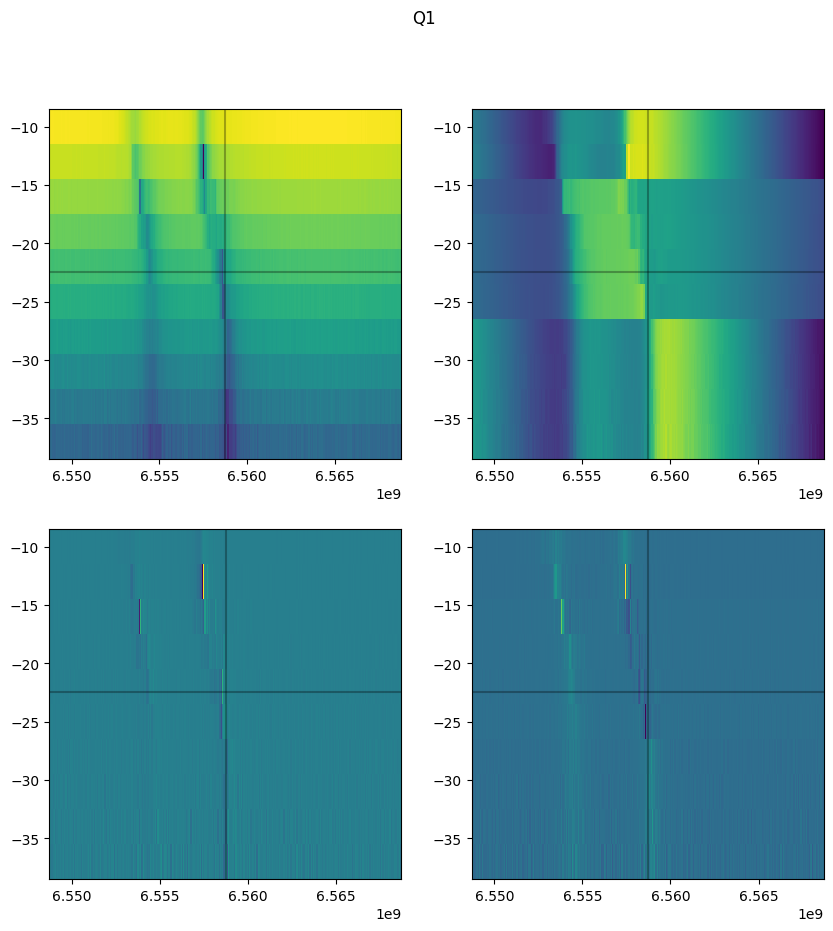

In [14]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
punchout.run_punchout_gui(qchip)

Click any plot to select desired resonator attenuation and frequency. If this is not a resonator, click outside the plot to remove from config


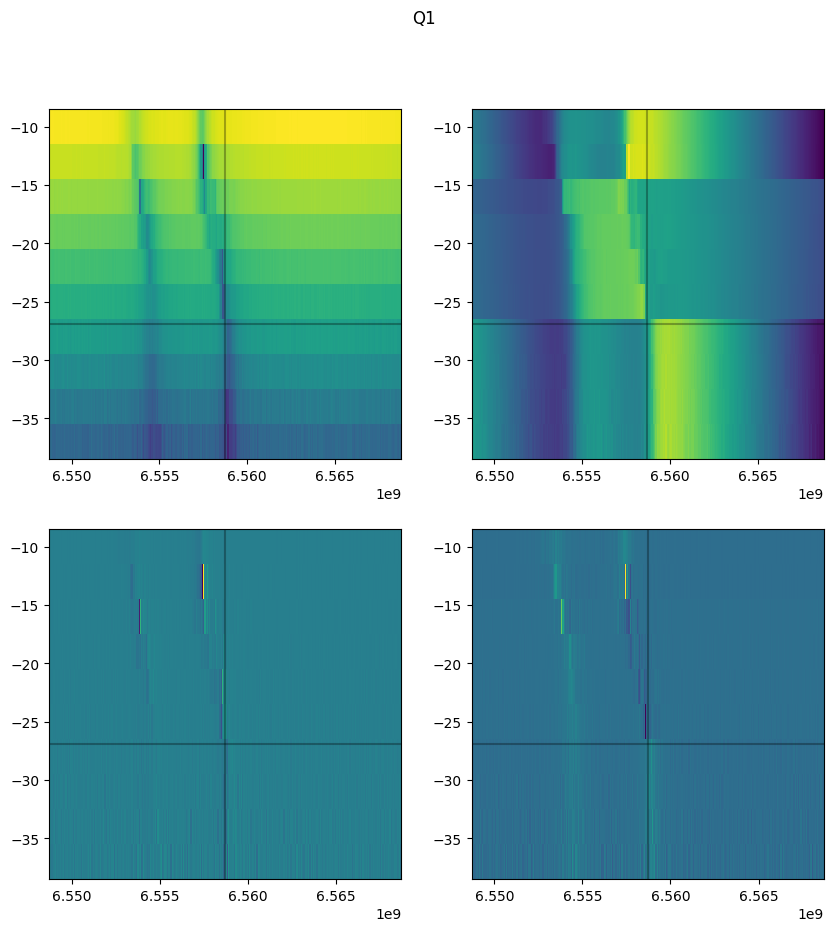

In [333]:
punchout.run_punchout_gui(qchip)

In [ ]:
asmparse.cmdparse

In [ ]:
acq_data_M=jobman.runner.load_and_run_acq(punchout.raw_asm_progs[0],n_total_shots=100, acq_chans={'0':2,'1':0},
                                          trig_delay=40e-6,decimator=0)

In [ ]:
acq_data_M['1']

In [ ]:
for c in ['0','1']:
    plt.xlabel('Time (s)')
    plt.ylabel('ACQ buf %s'%c)    
    plt.plot(np.arange(0,acq_data_M[c].shape[1]*0.5e-9,0.5e-9)[10:], np.average(acq_data_M[c],axis=0)[10:])
    #plt.show()
    #plt.plot(np.arange(0,acq_data_M['1'].shape[1]*0.5e-9,0.5e-9)[10:], np.average(acq_data_M['1'],axis=0)[10:])

# Alignment

In [ ]:
import qubic.toolchain as tc
qchip = qc.QChip(qchippath+'qubitcfg.json')
q='Q7'
rmodi={}
rmodi.update({(0,'amp'):1.0})
#rmodi.update({(1,'t0'):197.5e-9})
#rmodi.update({(0,'env',0,'paradict','alternate_period'):None,(1,'env',0,'paradict','alternate_period'):None})
circuit=[]
circuit.append({'name': 'delay', 't': 40e-6, 'qubit': q})
# circuit.append({'name': 'X90', 'qubit': q})
# circuit.append({'name': 'X90', 'qubit': q})
circuit.append({'name': 'read', 'qubit': q})
cp=tc.run_compile_stage(circuit,fpga_config,qchip)
print(cp)
ap=tc.run_assemble_stage(cp,channel_configs)

In [ ]:
acq_data=jobman.runner.load_and_run_acq(ap,n_total_shots=10, acq_chans={'0':2,'1':0},
                                          trig_delay=40e-6,decimator=0)

In [ ]:
np.set_printoptions(threshold=np.inf)
# print((acq_data['0']))

# np.save('data/111923/Q1_raw_state1.npy' ,acq_data['1'])
np.save('data/111623/dlo0_real.npy' ,acq_data['0'])
# np.save('data/111623/dlo0_imag.npy' ,acq_data['2'])


In [ ]:
for c in ['0','1']:
    plt.xlabel('Time (s)')
    plt.ylabel('ACQ buf %s'%c)    
    plt.plot(np.arange(0,acq_data[c].shape[1]*0.5e-9,0.5e-9)[10:], np.average(acq_data[c],axis=0)[10:])
    plt.show()

In [ ]:
for c in ['0','1']:
    plt.xlabel('Time (s)')
    plt.ylabel('ACQ buf %s'%c)    
    plt.plot(np.arange(0,acq_data[c].shape[1]*0.5e-9,0.5e-9)[10:], np.average(acq_data[c],axis=0)[10:])
    plt.show()

# Chevron 

In [469]:
from chipcalibration import chevron as ch
reload(ch)
qchip = qc.QChip(qchippath+'/qubitcfg.json')
# qubits = ['Q1', 'Q2','Q3']
# qubits = ['Q%d'%i for i in range(8)]
qubits = ['Q1']
nwidth = 40
pulse_widths = np.linspace(4.e-9, 400.e-9, nwidth)
nshot=20
nfreq = 50
fspan=20e6
centerfreq=None

In [470]:
for q in qubits:
    print(qchip.qubits[q].readfreq/1e6)
#    print(qchip.gates[q+'rabi_drag'].cfg_dict)
    print(qchip.gates[q+'read'].cfg_dict)

6558.59696969697
[{'freq': 'Q1.readfreq', 'phase': 0.0, 'dest': 'Q1.rdrv', 'twidth': 1.5e-06, 't0': 0.0, 'amp': 0.04, 'env': [{'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.01, 'twidth': 1.5e-06}}]}, {'freq': 'Q1.readfreq', 'phase': 1.450299717881593, 'dest': 'Q1.rdlo', 'twidth': 1.5e-06, 't0': 2e-07, 'amp': 1.0, 'env': [{'env_func': 'square', 'paradict': {'phase': 0.0, 'amplitude': 1.0, 'twidth': 1.5e-06}}]}]


## Chevron GE

In [471]:
chevron = ch.Chevron(qubits, fspan, nfreq, pulse_widths, qchip, fpga_config, channel_configs,centerfreq=centerfreq,
                     rabigate='rabi_drag')#cos')

In [472]:
%%time
chevron.run(runner, nshot)

delay_per_shot is deprecated and will be removed soon!


set label  0 0
set label  1 1
CPU times: user 662 ms, sys: 693 ms, total: 1.35 s
Wall time: 28.6 s


In [473]:
import qubic.state_disc as sd
reload(sd)
gmm = sd.GMMManager(chanmap_or_chan_cfgs=channel_configs)
gmm.fit(chevron.s11)
print(gmm.gmm_dict[q].fitdatetime)
gmm.set_labels_maxtomin({chan: shots[0].flatten() for chan, shots in chevron.s11.items()}, [0, 1])
state_disc_shots = gmm.predict(chevron.s11)
ones_frac = {qubit: np.sum(state_disc_shots[qubit], axis=2) for qubit in state_disc_shots.keys()}
jobman.update_gmm(gmm)
print(gmm.gmm_dict[q].gmmfit.means_)
print(gmm.gmm_dict[q].gmmfit.weights_)
print(gmm.gmm_dict[q].fitdatetime)
#result = gmm.predict(chevron.s11)

20231209_141727_PST
set label  1 0
set label  0 1
[[-77790.95735894  13836.83742812]
 [100010.33790709  15097.46220041]]
[0.32110078 0.67889922]
20231209_141727_PST


In [474]:
#import qubic.state_disc as sd
#reload(sd)
#gmm = sd.GMMManager(chanmap_or_chan_cfgs=channel_configs)
gmm.fit(chevron.s11)
print(gmm.gmm_dict[q].fitdatetime)
gmm.set_labels_maxtomin({chan: shots[0].flatten() for chan, shots in chevron.s11.items()}, [0, 1])
state_disc_shots = gmm.predict(chevron.s11)
ones_frac = {qubit: np.sum(state_disc_shots[qubit], axis=2) for qubit in state_disc_shots.keys()}
jobman.update_gmm(gmm)
print(gmm.gmm_dict[q].gmmfit.means_)
print(gmm.gmm_dict[q].gmmfit.weights_)
print(gmm.gmm_dict[q].fitdatetime)
#result = gmm.predict(chevron.s11)

20231209_141730_PST
set label  0 0
set label  1 1
[[100012.11131332  15097.41589248]
 [-77787.31601562  13836.98773034]]
[0.67888587 0.32111413]
20231209_141730_PST


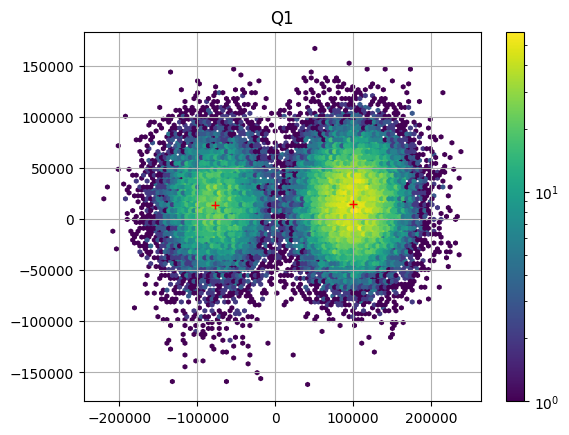

In [475]:
for q in qubits:
    l1=chevron.s11[str(channel_configs[q+'.rdrv'].core_ind)].reshape([-1,1])
    plt.hexbin(l1.real,l1.imag,bins='log')
    #plt.plot(l1.real,l1.imag,'.')
    c0=gmm.gmm_dict[q].gmmfit.means_[0]
    #c0=g.means_[0]
    
    plt.plot(c0[0],c0[1],'+',color='red')
    c1=gmm.gmm_dict[q].gmmfit.means_[1]
    #c1=g.means_[1]
    plt.plot(c1[0],c1[1],'+',color='red')
    plt.colorbar()
    plt.title(q)
    plt.grid()
    plt.show()

In [444]:
for q in qubits:
    p01=gmm.gmm_dict[q].gmmfit.means_
    l0=gmm.gmm_dict[q].labels[0]
    l1=gmm.gmm_dict[q].labels[1]
    p0=p01[l0][0]+1j*p01[l0][1]
    p1=p01[l1][0]+1j*p01[l1][1]
    angle=np.angle(p0-p1)%(2*np.pi)
    center=p0+(p1-p0)*1.0/2.0
    rph0=qchip.gates[q+'read'].contents[1].phase
    rph1=(rph0-angle)%(2*np.pi)
    if 1:
        qchip.gates[q+'read'].contents[1].phase=rph1
    if 1:
        qchip.save(qchippath+'/qubitcfg.json')
    print(rph0,rph1)

1.4590663735132643 1.450299717881593


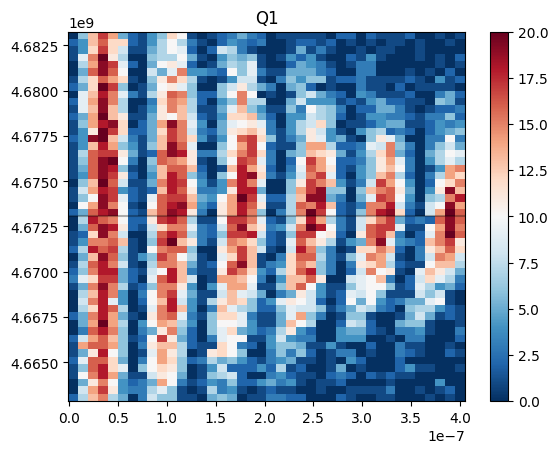

In [445]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
for q in qubits:
    y=qchip.qubits[q].freq
    plt.axhline(y=y,color='black',alpha=0.3)
    plt.pcolormesh(chevron.pulse_widths, chevron.centerfreq[q]+chevron.freqoffsets, np.array(ones_frac[q].T,dtype=np.float32), cmap='RdBu_r')
    plt.colorbar()
    plt.title(q)
    plt.show()

In [446]:
gmm.savejson(qchippath+'gmm.json')

In [447]:
qubits

['Q1']

Q1


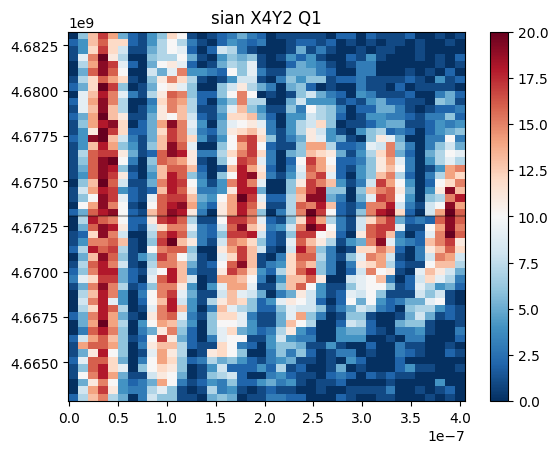

In [448]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
for q in qubits:
    plt.pcolormesh(chevron.pulse_widths, chevron.centerfreq[q]+chevron.freqoffsets, np.array(ones_frac[q].T,dtype=np.float32), cmap='RdBu_r')
    print(q)
    plt.clim(0,nshot)
    plt.title('%s %s %s'%(board,str(chip),str(q)))
    y=qchip.qubits[q].freq
    plt.axhline(y=y,color='black',alpha=0.3)
    plt.colorbar()
    plt.show()

In [449]:
gmm.gmm_dict['Q1'].fitdatetime

'20231209_141139_PST'

## Chevron EF

In [450]:
chevronef = ch.Chevron(qubits, fspan, nfreq, pulse_widths, qchip, fpga_config, channel_configs,centerfreq=centerfreq
                       ,rabigate='rabi_ef',ef=True,ef_rotate_back=0)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
%%time
chevronef.run(runner, nshot)

In [ ]:
dir(jobman)

In [ ]:
import qubic.state_disc as sd
reload(sd)
#gmm = sd.GMMManager(chanmap_or_chan_cfgs=channel_configs,n_states=3)
gmm = sd.GMMStateDiscriminator(n_states=3)
gmm.fit(iqdata=chevronef.s11[])
# print(gmm.gmm_dict[q].fitdatetime)
# gmm.set_labels_maxtomin({chan: shots[0].flatten() for chan, shots in chevronef.s11.items()}, [0, 1, 2])
# state_disc_shots = gmm.predict(chevronef.s11)
# ones_frac = {qubit: np.sum(state_disc_shots[qubit], axis=2) for qubit in state_disc_shots.keys()}
# jobman.update_gmm(gmm)
# print(gmm.gmm_dict[q].gmmfit.means_)
# print(gmm.gmm_dict[q].gmmfit.weights_)
# print(gmm.gmm_dict[q].fitdatetime)
#result = gmm.predict(chevron.s11)

In [ ]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
for q in qubits:
    y=qchip.qubits[q].freq_ef
    plt.axhline(y=y,color='black',alpha=0.3)
    plt.pcolormesh(chevronef.pulse_widths, chevronef.centerfreq[q]+chevronef.freqoffsets, ones_frac[q].T,cmap='RdBu_r')
    plt.colorbar()
    plt.title(q)
    plt.show()

In [ ]:
labels=gmm.gmm_dict[q].labels
for q in qubits:
    l1=chevronef.s11[str(channel_configs[q+'.rdrv'].core_ind)].reshape([-1,1])
    plt.hexbin(l1.real,l1.imag,bins='log')
    #plt.plot(l1.real,l1.imag,'.')
    c0=gmm.gmm_dict[q].gmmfit.means_[0]
    #c0=g.means_[0]
    plt.plot(c0[0],c0[1],marker='$%s$'%labels[0],color='red')
    c1=gmm.gmm_dict[q].gmmfit.means_[1]
    #c1=g.means_[1]
    plt.plot(c1[0],c1[1],marker='$%s$'%labels[1],color='red')
    c2=gmm.gmm_dict[q].gmmfit.means_[2]
    #c1=g.means_[1]
    plt.plot(c2[0],c2[1],marker='$%s$'%labels[2],color='red')
    plt.colorbar()
    plt.title(q)
    plt.grid()
    plt.show()

# Amplitude Rabi 

In [451]:
import chipcalibration.rabi_amp_sweep as rabiamp
reload(rabiamp)
qchip = qc.QChip(qchippath+'/qubitcfg.json')
#target_qubits = ['Q0', 'Q1', 'Q2', 'Q3']
#qubits = ['Q0','Q1','Q2']
# qubits = ['Q7']
# qubits = ['Q0','Q1','Q2','Q3']
qubits = ['Q%d'%i for i in range(8)]
qubits = ['Q1']
target_twidth = 32e-9
num_partitions = 50
irabiamp = rabiamp.RabiAmpSweeper(qubits, target_twidth, qchip, fpga_config, channel_configs,
                                  num_partitions=num_partitions,rabigate='rabi_drag',repeat=4)
# fit is A*sin(2*pi*x/drive_period + phi) + B, params are [A, B, drive_period, phi]
prior_fit_params = {
    'Q0' : [-0.5, 0.5, 0.5, 0], 
    'Q1' : [-0.5, 0.5, 0.8, 0], 
    'Q2' : [-0.5, 0.5, 0.8, 0], 
    'Q3' : [-0.5, 0.5, 0.8, 0], 
    'Q4' : [-0.5, 0.5, 0.8, 0], 
    'Q5' : [-0.5, 0.5, 0.8, 0], 
    'Q6' : [-0.5, 0.5, 0.8, 0], 
    'Q7' : [-0.5, 0.5, 0.8, 0], 
}

In [452]:
tstart=time.time()
irabiamp.run_and_fit(jobman, 1000, prior_fit_params,qchip=qchip)
print('time',time.time()-tstart)

Taking data for qubit Q1 in batch 1 of 1
set label  0 0
set label  1 1
time 25.048206090927124


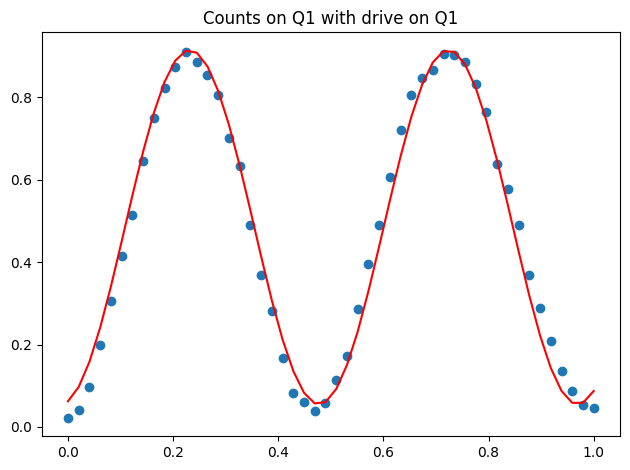

In [453]:
for q in qubits:
    irabiamp.show_count_oscillations(q, qubits, show_fits=True)

# X = amplitude , Y= pobability

In [454]:
q
irabiamp.fits[q]

(array([-0.43008327,  0.48502748,  0.49203986, -0.18718789]),
 array([[ 6.17829516e-05, -5.54187646e-07, -1.94538583e-06,
          2.70552138e-05],
        [-5.54187646e-07,  3.61458410e-05, -5.93499758e-06,
          7.57805594e-05],
        [-1.94538583e-06, -5.93499758e-06,  7.63169542e-06,
         -9.56082266e-05],
        [ 2.70552138e-05,  7.57805594e-05, -9.56082266e-05,
          1.54823697e-03]]))

In [455]:
calibrated_X90_drive_amps = {qid: irabiamp.fits[qid][0][2] for qid in qubits}
print(calibrated_X90_drive_amps)

{'Q1': 0.4920398625653424}


In [456]:
if 1:
    import qubic.state_disc as sd
    gmm = sd.GMMManager(chanmap_or_chan_cfgs=channel_configs)
    gmm.fit(irabiamp.all_raw_data)
#     p01=gmm.gmm_dict[q].gmmfit.means_
#     l0=gmm.gmm_dict[q].labels[0]
#     l1=gmm.gmm_dict[q].labels[1]
#     p0=p01[l0][0]+1j*p01[l0][1]
#     p1=p01[l1][0]+1j*p01[l1][1]
#     angle=np.angle(p0-p1)%(2*np.pi)
#     center=p0+(p1-p0)*1.0/2.0
#     rph0=qchip.gates[q+'read'].contents[1].phase
#     rph1=(rph0-angle)%(2*np.pi)
#     if 1:
#         qchip.gates[q+'read'].contents[1].phase=rph1
    if 1:
        qchip.save(qchippath+'/qubitcfg.json')
    #print(rph0,rph1)
jobman.update_gmm(irabiamp.gmm_manager)

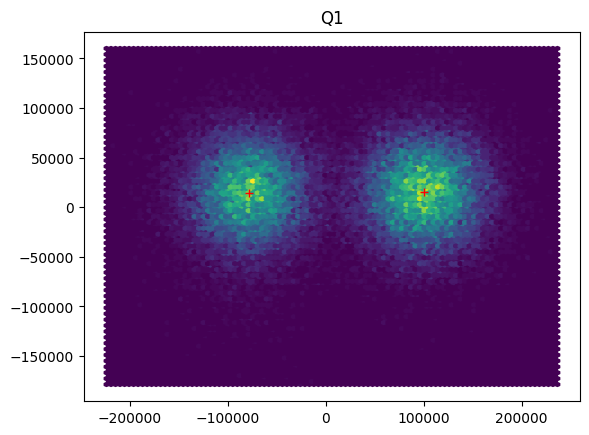

In [457]:
for q in qubits:
    core_ind=channel_configs[q+'.qdrv'].core_ind
    chval =irabiamp.all_raw_data[str(core_ind)]
    plt.hexbin(chval.real,chval.imag)
    plt.title(q)
    c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
    #c0=g.means_[0]
    plt.plot(c0[0],c0[1],'+',color='red')
    c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
    #c1=g.means_[1]
    plt.plot(c1[0],c1[1],'+',color='red')
    plt.show()

In [458]:
if 1:
    irabiamp.update_qchip(qchip,ratio=1.0)
    qchip.save(qchippath+'/qubitcfg.json')

In [459]:
if 1:
    jobman.gmm_manager.savejson(qchippath+'gmm.json')

# Time Rabi

In [430]:
import chipcalibration.rabi_experiments as rabi_experiments
reload(rabi_experiments)
from chipcalibration.rabi_experiments import TimeRabi 

In [431]:
q='Q1'
taxis=np.linspace(0.e-9, 240e-9, 40)
irabitime = TimeRabi(target_qubit=[q], readout_register=[q], drive_amplitude=calibrated_X90_drive_amps[q], 
                     pulse_width_interval=taxis, rabigate='rabi_drag')

In [432]:
# comment out twidth in env
# q='Q0'
# taxis=np.linspace(0.e-9, 240e-9, 40)
# irabitime = TimeRabi(target_qubit=[q], readout_register=[q], pulse_width_interval=taxis, rabigate='X90') 
# qchip = qc.QChip(qchippath+'/qubitcfg.json')

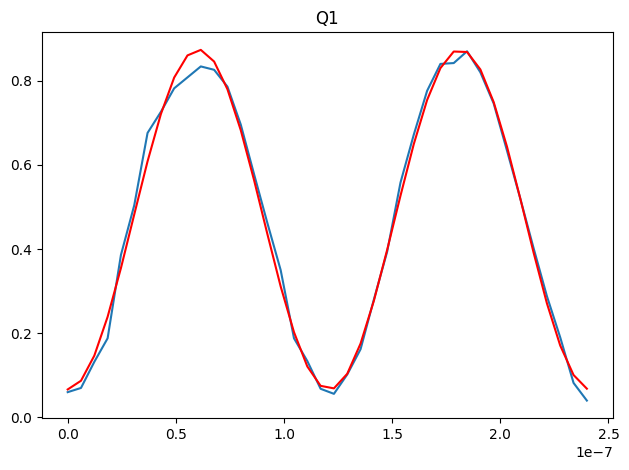

[3.0235386249943e-08, 0.49384749979082193]

In [433]:
irabitime.run_and_report(jobman, 500, qchip)

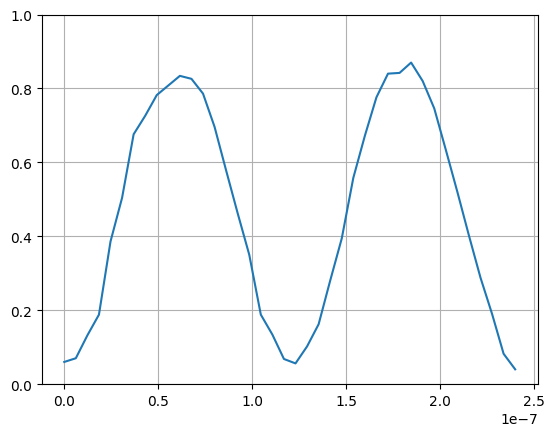

In [434]:
plt.plot(taxis,np.average(irabitime.shots[q], axis=1))
plt.ylim((0,1))
plt.grid()

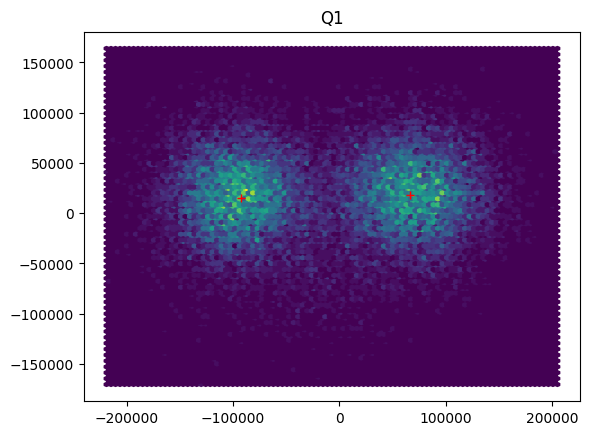

In [46]:
#for qubit in [q]:
if 1:    
    core_ind=channel_configs[q+'.qdrv'].core_ind
    #chval =rabi.shots[str(core_ind)]
    chval =irabitime.raw_IQ[str(core_ind)]
    plt.hexbin(chval.real,chval.imag)
    plt.title(q)
    c0=gmm.gmm_dict[q].gmmfit.means_[0]
    plt.plot(c0[0],c0[1],'+',color='red')
    c1=gmm.gmm_dict[q].gmmfit.means_[1]
    plt.plot(c1[0],c1[1],'+',color='red')
    plt.show()

# Ramsey

In [379]:
import chipcalibration.ramsey1 as ramsey
reload(ramsey)
#from chipcalibration.ramsey1 import ramsey,ramsey_optimize
from chipcalibration.ramsey1 import ramsey_optimize
qchip = qc.QChip(qchippath+'qubitcfg.json')
q='Q1'
estimated_t2ramsey=30e-6
delay_interval=np.linspace(0,2*estimated_t2ramsey,100)
#delay_interval=np.zeros(10)
#iramsey=ramsey(qubit=q,delay_interval=delay_interval,qchip=qchip)
iramsey=ramsey.Ramsey(qubit=q,delay_interval=delay_interval,qchip=qchip)

## Plus minus frequency

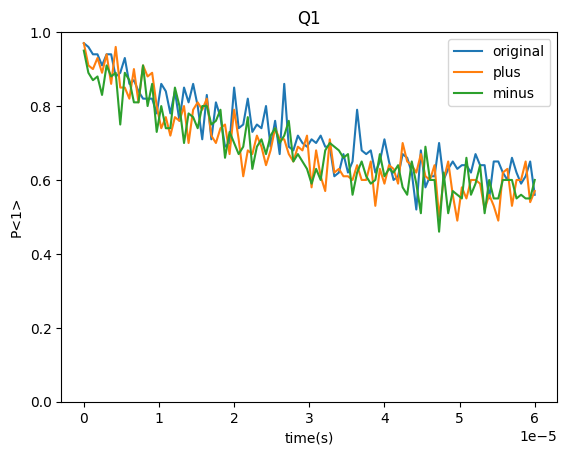

In [380]:
# print(iramsey.circuits)
iramsey.plusminus(jobmanager=jobman,num_shots_per_circuit=100)

In [159]:
iramsey.update_qchip(qchip)

In [160]:
if 1:
    qchip.save(qchippath+'qubitcfg.json')

## Simple Ramsey

In [ ]:
%%time
iramsey.ramsey(framsey_offset=0,fastreset=None)
p1=iramsey.run_and_report(jobmanager=jobman, num_shots_per_circuit=100)

In [ ]:
plt.plot(iramsey.delay_interval,iramsey.p1)
plt.title(q)
plt.ylim((0,1))

In [ ]:
print(iramsey.output_dict['shots']['Q1'].shape)
plt.plot(np.mean(iramsey.output_dict['shots']['Q1'][:,:,2::3],axis=1).flatten())
plt.ylim((0,1))

## V shape ramsey frequency optimze

In [124]:
framsey_offsets=np.linspace(-200e3,200e3,6)
ramsop=ramsey_optimize(qubit=q,delay_interval=delay_interval,qchip=qchip,framsey_offsets=framsey_offsets,
                       jobmanager=jobman,num_shots_per_circuit=100)
foffset=ramsop['absfit'][0][0]
print(f'{foffset=}')

foffset=717.1841234476422


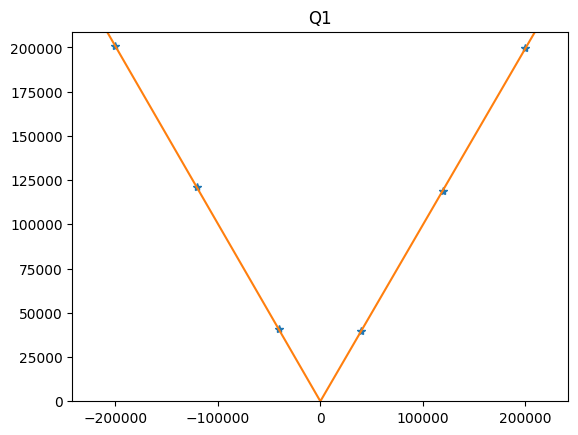

In [125]:
plt.plot(ramsop['x'],ramsop['y'],'*')
xlim=plt.gca().get_xlim()
ylim=plt.gca().get_ylim()
xplot=(xlim[0],0,xlim[1])
x0=ramsop['absfit'][0][0]
yplot=[abs(x-x0) for x in (xlim[0],x0,xlim[1])]
plt.plot(xplot,yplot)
plt.title(q)
y=plt.ylim((0,ylim[1]))

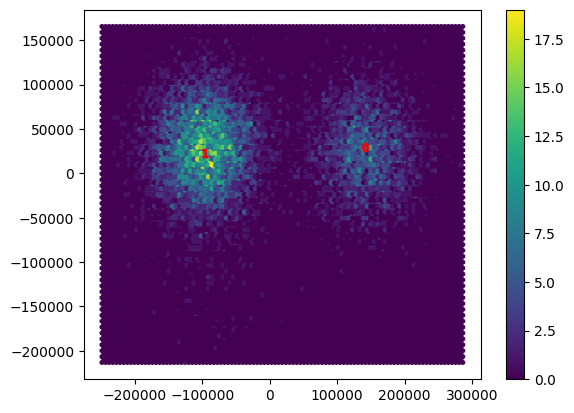

In [126]:
core_ind=str(channel_configs[q+'.qdrv'].core_ind)
plt.hexbin(iramsey.raw_IQ[core_ind].real,iramsey.raw_IQ[core_ind].imag)
plt.colorbar()
labels=jobman.gmm_manager.gmm_dict[q].labels
c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
plt.plot(c0[0],c0[1],marker='$%s$'%labels[0],color='red')
c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
plt.plot(c1[0],c1[1],marker='$%s$'%labels[1],color='red')

# Stack X90

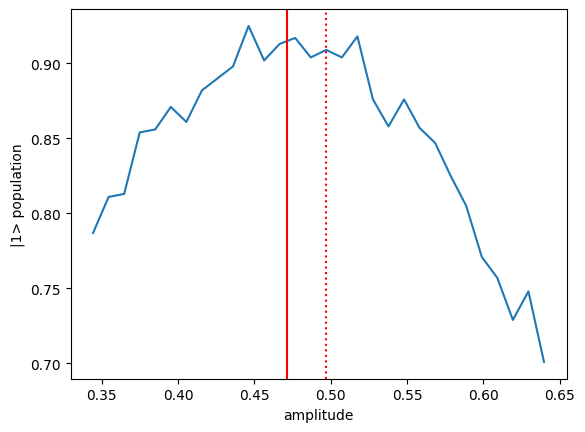

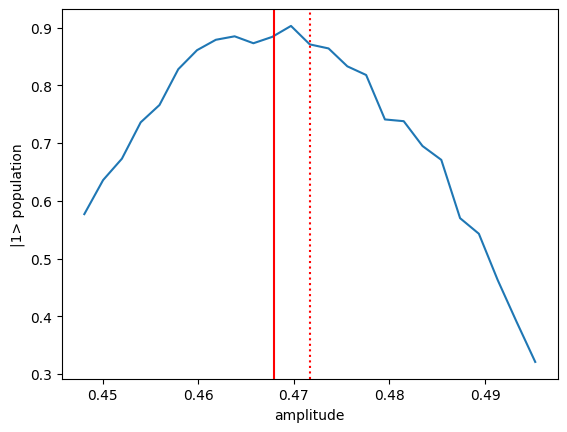

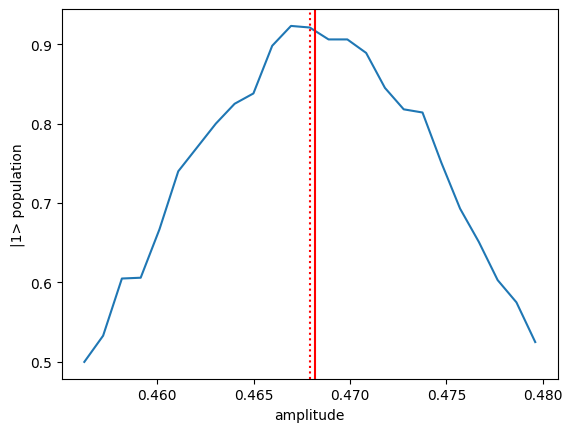

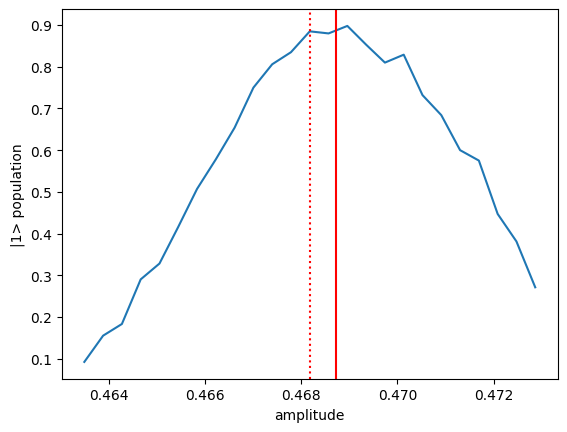

In [460]:
import chipcalibration.graph as graph
import chipcalibration.repeated_xgates as rx
qchip = qc.QChip(qchippath+'/qubitcfg.json')
qubits=['Q1']
reload(rx)
initratio=dict(Q0=0.1,Q1=0.3,Q7=0.25,Q5=0.3,Q2=0.3,Q3=0.3,Q4=0.2,Q6=0.15)
cal_graph = graph.CalibrationGraph()
for qubit in qubits:
    cal_graph.add_calibration_step('{}_stack_0'.format(qubit), 
                                   rx.XGateRepetition([qubit], initratio[qubit], 30, 0), 
                                   [qubit], shots_per_circuit=1000)
    cal_graph.add_calibration_step('{}_stack_1'.format(qubit), 
                                   rx.XGateRepetition([qubit], 0.05, 25, 5), 
                                   [qubit], predecessor_nodes=['{}_stack_0'.format(qubit)], shots_per_circuit=1000)
                                #    [qubit], shots_per_circuit=1000)
    cal_graph.add_calibration_step('{}_stack_2'.format(qubit), 
                                   rx.XGateRepetition([qubit], 0.025, 25, 10), 
                                   [qubit], predecessor_nodes=['{}_stack_1'.format(qubit)], shots_per_circuit=1000)
    cal_graph.add_calibration_step('{}_stack_3'.format(qubit), 
                                   rx.XGateRepetition([qubit], 0.01, 25, 40), 
                                   [qubit], predecessor_nodes=['{}_stack_2'.format(qubit)], shots_per_circuit=1000)
cal_graph.run_calibration(jobman, qchip, show_plots=True)    

In [461]:
#a=rx.XGateRepetition([qubit], initratio[qubit], 30, 0)
#a.run_and_report(jobman, 100, qchip)

In [462]:
if 1:
    qchip.save(qchippath+'qubitcfg.json')

# Drag alpha

In [463]:
import chipcalibration.dragalpha as dragalpha
reload(dragalpha)
from chipcalibration.dragalpha import dragalpha

qubit='Q1'
alphas=np.arange(-3,3,0.1)
idragalpha=dragalpha(qubit=qubit,alphas=alphas)


In [464]:
idragalpha.run_and_report(jobmanager=jobman,num_shots_per_circuit=1000,qchip=qchip)

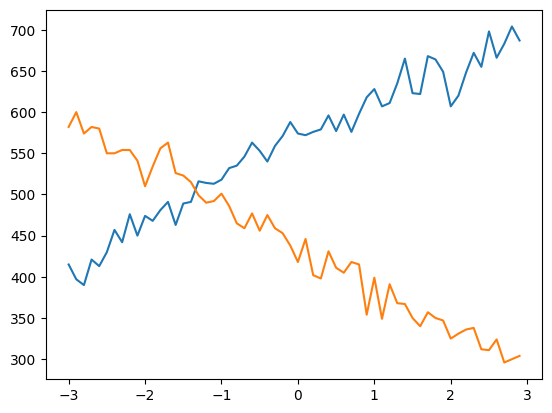

In [465]:
plt.plot(alphas,idragalpha.x90y180,label='x90y180')
plt.plot(alphas,idragalpha.y90x180,label='y90x180')

In [466]:
idragalpha.fit()

-1.259335929285468

In [467]:
idragalpha.update_qchip(qchip=qchip)
if 1:
    qchip.save(qchippath+'qubitcfg.json')

In [468]:
qchippath

'chipcalibration/submodules/qchip/X4Y2/sian/'

# Readout Frequency optimization by blob separation

In [283]:
import chipcalibration.blobs as blobs
reload(blobs)
from chipcalibration.blobs import blobs

qchip = qc.QChip(qchippath+'qubitcfg.json')
qubits=['Q0','Q1']

qubits=['Q0','Q1','Q2']
qubits=['Q1']
iblobs={}
for q in qubits:
    iblobs[q]=blobs(qubit=q,qchip=qchip)

## blobfreq

In [284]:
dfreads=np.linspace(-3e6,3e6,100)
blobres={}
for q in qubits:
    iblobs[q].blobfreq(dfreads=dfreads)
    blobres[q]=iblobs[q].run_and_report(jobmanager=jobman,num_shots_per_circuit=200)

delay_per_shot is deprecated and will be removed soon


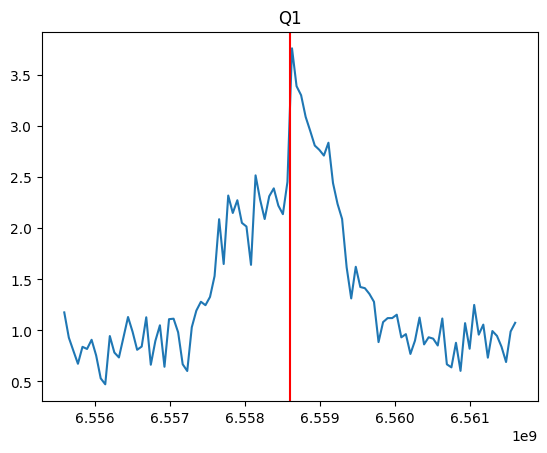

In [285]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
for q in qubits:
    plt.plot(blobres[q]['x'],[d[(0,1)] for d in blobres[q]['dists']])
    plt.axvline(x=qchip.qubits[q].readfreq,color='red')
    plt.title(q)
    plt.show()

In [286]:
index=0
max=float('-inf')
for i in range(len(blobres[q]['dists'])):
    if max < (blobres[q]['dists'][i][(0,1)]):
        index = i
        max = blobres[q]['dists'][i][(0,1)]
print(index,max)
print(blobres[q]['x'][index])

50 3.759708937412685
6558627272.727273


In [84]:
# qchip.qubits['Q0'].readfreq=6.5543e9
qchip.qubits['Q1'].readfreq=6558519696.969697
qchip.save(qchippath+'qubitcfg.json')

## blobamp

In [ ]:
amps=np.linspace(0,0.3,100)
blobres={}
for q in qubits:
    iblobs[q].blobamp(amps=amps)
    blobres[q]=iblobs[q].run_and_report(jobmanager=jobman,num_shots_per_circuit=100)

In [ ]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
for q in qubits:
    plt.plot(blobres[q]['x'],[d[(0,1)] for d in blobres[q]['dists']])
    plt.axvline(x=qchip.gates['%sread'%q].contents[0].amp,color='red')
    plt.title(q)
    plt.show()

## blobt0

In [ ]:
t0s=np.linspace(0,600e-9,100)
blobres={}
for q in qubits:
    iblobs[q].blobt0(t0s=t0s)
    blobres[q]=iblobs[q].run_and_report(jobmanager=jobman,num_shots_per_circuit=1000)

In [ ]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
for q in qubits:
    plt.plot(blobres[q]['x'],[d[(0,1)] for d in blobres[q]['dists']])
    plt.axvline(x=qchip.gates['%sread'%q].contents[1].t0,color='red')
    plt.title(q)    
    plt.show()

## blob3 freq

In [ ]:
import chipcalibration.blob3 as blob3
reload(blob3)
from chipcalibration.blob3 import blob3

qchip = qc.QChip(qchippath+'qubitcfg.json')
qubits=['Q0','Q1']

qubits=['Q0','Q1','Q7']
qubits=['Q1']
iblob3={}
for q in qubits:
    iblob3[q]=blob3(qubit=q,qchip=qchip)


In [ ]:
dfreads=np.linspace(-3e6,3e6,100)
blobres={}
for q in qubits:
    iblob3[q].blobfreq(dfreads=dfreads)
    blobres[q]=iblob3[q].run_and_report(jobmanager=jobman,num_shots_per_circuit=200)

In [ ]:
debug

In [ ]:
iblob3['Q1'].raw_IQ['4'].shape

In [ ]:
plt.plot(blobres['Q1']['x'],[blobres['Q1']['dists'][i][(0,1)] for i in range(len(blobres['Q1']['x']))],'.')
plt.plot(blobres['Q1']['x'],[blobres['Q1']['dists'][i][(0,2)] for i in range(len(blobres['Q1']['x']))],'.')
plt.plot(blobres['Q1']['x'],[blobres['Q1']['dists'][i][(1,2)] for i in range(len(blobres['Q1']['x']))],'.')
min3=[min(d.values()) for d in blobres['Q1']['dists']]
f3=blobres['Q1']['x'][min3.index(max(min3))]
print(f3)
plt.axvline(x=f3)

In [ ]:
blobres['Q1']['dists'][3][(0,1)]

# rcal

In [ ]:
import chipcalibration.rcal as rcal
reload(rcal)

qchip = qc.QChip(qchippath+'qubitcfg.json')
qubits=['Q0','Q1','Q7']
qubits=['Q0','Q1']
ircal={}
for qubit in qubits:
    ircal[qubit]=rcal.Rcal(drvqubit=qubit, readqubits=[qubit],
                           qchip=qchip, fpga_config=fpga_config, channel_configs=channel_configs)
    ircal[qubit].run(circuit_runner=jobman.runner,nsamples=10000)
    print(qubit,np.array(((ircal[qubit].prep0_read0[qubit][0],ircal[qubit].prep0_read1[qubit][0])
                          ,(ircal[qubit].prep1_read0[qubit][0],ircal[qubit].prep1_read1[qubit][0]))))
    p01=ircal[qubit].gmm_manager.gmm_dict[qubit].gmmfit.means_
    l0=ircal[qubit].gmm_manager.gmm_dict[qubit].labels[0]
    l1=ircal[qubit].gmm_manager.gmm_dict[qubit].labels[1]
    p0=p01[l0][0]+1j*p01[l0][1]
    p1=p01[l1][0]+1j*p01[l1][1]
    angle=np.angle(p0-p1)%(2*np.pi)
    center=p0+(p1-p0)*1.0/2.0
    rph0=qchip.gates[qubit+'read'].contents[1].phase
    rph1=(rph0-angle)%(2*np.pi)
    if 1:
        qchip.gates[qubit+'read'].contents[1].phase=rph1    
    if 1:
        jobman.update_gmm(ircal[qubit].gmm_manager)


In [ ]:
if 1:
    qchip.save(qchippath+'/qubitcfg.json')
print(rph0,rph1)

In [ ]:
#plt.hexbin(ircal.s11['0'].real.flatten(),ircal.s11['0'].imag.flatten())
for q in qubits:
    core_ind=str(channel_configs[q+'.qdrv'].core_ind)
    plt.hexbin(ircal[q].s11[core_ind].real.flatten(),ircal[q].s11[core_ind].imag.flatten())
    plt.colorbar()
    labels=jobman.gmm_manager.gmm_dict[q].labels
    c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
    plt.plot(c0[0],c0[1],marker='$%s$'%labels[0],color='red')
    c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
    plt.plot(c1[0],c1[1],marker='$%s$'%labels[1],color='red')
    plt.title(q)
    plt.show()

# Single qubit Streamlined Randomized Benchmarking using TrueQ (SRB)

In [476]:
import trueq as tq
import qubic.trueq.transpiler as tp
import qubic.trueq.job_manager as tqj
jobman_tq = tqj.TrueQJobManager(fpga_config, qchip, channel_configs, runner, gmm_manager=jobman.gmm_manager)
#tqcircuits = tq.make_srb(0, [4, 32, 128, 256,384, 512], 30) #, compiled_pauli=False)
tqcircuits = tq.make_srb(0, [4, 128, 256, 512], 20) #, compiled_pauli=False)
c=tqcircuits.append(tq.make_rcal(tqcircuits.labels))
#circuits = tq.make_srb(0, [4, 10, 50, 100, 200], 30)

In [477]:
def run_rb(qubit, circuits, nshots=1000):
    res = jobman_tq.build_and_run_circuits(circuits, [qubit], 1000, outputs=['counts', 'trueq_results'], 
                                    fit_gmm=False, delay_per_shot=0, delay_before_circuit=500.e-6)
    return res

Q1


delay_per_shot is deprecated and will be removed soon


Twirling with
Cliffords on [0]
---------------------------
SRB |Fit on Labels:       |
    |         (0,)        |
---------------------------
 A  | 9.87e-01 (5.85e-03) |
 p  | 9.99e-01 (3.23e-05) |
e_F | 5.75e-04 (2.42e-05) |
---------------------------

RCal Estimate on (0,):
---------------------------
 RCAL |     Confusion     |
---------------------------
      |  P(0|0) | P(1|1)  |
---------------------------
 (0,) |  0.975  | 0.943   |
---------------------------




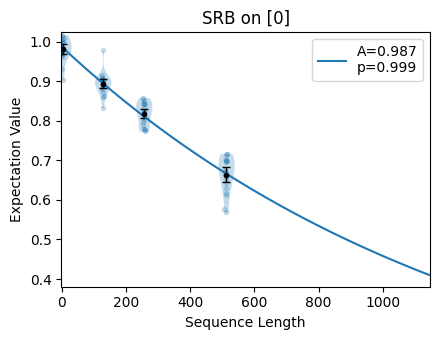

In [478]:
# qubits=['Q0','Q1','Q2']
#qubits=['Q0','Q1','Q2','Q3','Q4','Q5','Q6','Q7']
qubits=['Q1']
res={}
for q in qubits:
    print(q)
    res[q]=run_rb(qubit=q,circuits=tqcircuits)
    tqcircuits.results=res[q]['trueq_results']
    print(tqcircuits.fit())    
    tqcircuits.plot.raw()
    plt.show()

In [401]:
jobman.gmm_manager.savejson(qchippath+'gmm.json')

In [402]:
jobman_tq.job_manager.runner

Twirling with
Cliffords on [0]
---------------------------
SRB |Fit on Labels:       |
    |         (0,)        |
---------------------------
 A  | 9.86e-01 (7.64e-03) |
 p  | 9.99e-01 (4.41e-05) |
e_F | 6.27e-04 (3.31e-05) |
---------------------------

RCal Estimate on (0,):
---------------------------
 RCAL |     Confusion     |
---------------------------
      |  P(0|0) | P(1|1)  |
---------------------------
 (0,) |  0.965  | 0.926   |
---------------------------




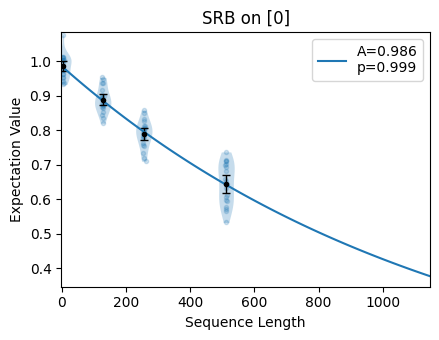

In [403]:
print(tqcircuits.fit())  
tqcircuits.plot.raw()

# Readout for ML

In [479]:
%%time
qchip = qc.QChip(qchippath+'qubitcfg.json')
qid = ['Q1']
for q in qid:
    circuits = []
    circuit = []
    circuit.append({'name': 'delay', 't': 600e-6, 'qubit': q})
    circuit.append({'name': 'read', 'qubit': q})
    circuit.append({'name': 'delay', 't': 12e-6, 'qubit': q})
    circuit.append({'name': 'read', 'qubit': q})
    circuit.append({'name': 'delay', 't': 600e-6, 'qubit': q})    
    circuit.append({'name': 'read', 'qubit': q})
    circuit.append({'name': 'delay', 't': 12e-6, 'qubit': q})
    circuit.append({'name': 'X90', 'qubit': q})
    circuit.append({'name': 'X90', 'qubit': q})
    circuit.append({'name': 'read', 'qubit': q})
    circuits.append(circuit)
    output_dict = jobman.collect_all(program_list=circuits,num_shots_per_circuit=20000,reads_per_shot=4,qchip=qchip)
    raw_IQ = output_dict['s11']
    h0_g = sum(output_dict['shots'][q][0][:,0]==0)
    h0m0_g = (np.sum(np.all(output_dict['shots'][q][0][:,0:2]==[0,0],axis=1)))
    p_g = h0m0_g/h0_g
    h0_e = sum(output_dict['shots'][q][0][:,2]==0)
    h0m1_e = (np.sum(np.all(output_dict['shots'][q][0][:,2:4]==[0,1],axis=1)))
    p_e = h0m1_e/h0_e
    print(q,'Ground',h0_g,h0m0_g,p_g)
    print(q,'Excited',h0_e,h0m1_e,p_e)

Q1 Ground 19078 18946 0.993081035747982
Q1 Excited 19415 18977 0.977440123615761
CPU times: user 31.6 ms, sys: 0 ns, total: 31.6 ms
Wall time: 33.4 s


In [ ]:
print((output_dict))

In [480]:
state0 = output_dict['s11']['4'][0][:,1]
state1 = output_dict['s11']['4'][0][:,3]
print(state0.shape,state1.shape)

np.save('data/120923/state0_15µs_cos.npy', state0)
np.save('data/120923/state1_15µs_cos.npy', state1)


(20000,) (20000,)


# Cross Resonance (CR) scan

In [ ]:
import chipcalibration.tcr as tcr
reload(tcr)

In [ ]:
control_qubit='Q1'
target_qubit='Q0'
itcrtwidth = tcr.tcr(control_qubit=control_qubit,target_qubit=target_qubit)

## CR pulse length (twidth and amp)

In [ ]:
twidths=np.linspace(100e-9,400e-9,50)
amps=[0.5,0.7,1.0]
amps=[0.8]
itcrtwidth.cr_amp_width_sweep(twidths=twidths,amps=amps)
starttime=time.time()
c0,c1,r=itcrtwidth.run_and_report(jobmanager=jobman,num_shots_per_circuit=100,qchip=qchip)
print('time',time.time()-starttime)

In [ ]:
fig=plt.figure(figsize=(6,6))
ax=fig.subplots(4)
for itomo,tomo in enumerate(['x','y','z']):
    for iamp,amp in enumerate(amps):
        ax[itomo].plot(twidths,c0[target_qubit][:,iamp,itomo],label='%s %8.2f'%('c0',amp),color='r')
        ax[itomo].plot(twidths,c1[target_qubit][:,iamp,itomo],label='%s %8.2f'%('c1',amp),color='g')
        ax[itomo].set_ylabel(tomo)
        ax[itomo].set_ylim((-1,1))
    #ax[itomo].legend()
for iamp,amp in enumerate(amps):
    ax[3].plot(twidths,r[target_qubit][:,iamp],'*-',label='%s %8.2f'%('r',amp))
#ax[3].legend()
ax[3].legend(bbox_to_anchor=(1.1, 1.05))
ax[3].set_ylim((0,1))

## CR pulse amplitude only

In [ ]:
control_qubit='Q1'
target_qubit='Q0'
itcramp = tcr.tcr(control_qubit=control_qubit,target_qubit=target_qubit)
amps = np.linspace(0.08,0.98,31)
itcramp.cr_amp_sweep(amps=amps,repeat=1)

In [ ]:
%%time
c0,c1,r=itcramp.run_and_report(jobmanager=jobman,num_shots_per_circuit=100,qchip=qchip)

In [ ]:
fig=plt.figure(figsize=(6,6))
ax=fig.subplots(4)
for itomo,tomo in enumerate(['x','y','z']):
    ax[itomo].plot(amps,c0[target_qubit][0,:,itomo],label='%s'%('c0'))
    ax[itomo].plot(amps,c1[target_qubit][0,:,itomo],label='%s'%('c1'))
    ax[itomo].set_ylabel(tomo)
    ax[itomo].set_ylim((-1,1))
    ax[itomo].legend()
ax[3].plot(amps,r[target_qubit][0,:],label='%s'%('r'))
ax[3].legend()
ax[3].set_ylim((0,1))

In [ ]:
def quadratic(t,a,b,c):
    return a*(t-b)**2+c

In [ ]:
popt,pcov = curve_fit(quadratic,amps,r['Q0'][0,:])
rfit=quadratic(amps,*popt)
plt.plot(amps,r['Q0'][0,:])
plt.plot(amps, rfit, label='fit')    
print(popt[1])
if 1:
    qchip.gates['Q1Q0CR'].contents[0].amp=popt[1]
    qchip.gates['Q1Q0CNOT'].contents[1].amp=popt[1]
    qchip.save(qchippath+'/qubitcfg.json')

# Full XY scan

# fullxy scan search CNOT from CR

In [ ]:
import chipcalibration.fullxycnot as fullxycnot
reload(fullxycnot)

zprepdeg = np.array([[246,147],[314,234],[336,37]])
#zprepdeg = np.array([[246,147],[315,234],[335,37]])
#zprepdeg=np.random.rand(3,2)*360

zprep = zprepdeg/360*2*np.pi
xyrot = np.linspace(0,2*np.pi,200)
axes=('Y')
control_qubit = 'Q1'
target_qubit = 'Q0'

qchip = qc.QChip(qchippath+'qubitcfg.json')

ifullxy = fullxycnot.fullxycnot(control_qubit='Q1',target_qubit='Q0',xyrot=xyrot,zprep=zprep,axes=axes)


In [ ]:
starttime=time.time()
ifullxy.run_and_report(jobmanager=jobman,num_shots_per_circuit=200,qchip=qchip)
print('time(s)',time.time()-starttime)

In [ ]:
fitval=ifullxy.fit()

In [ ]:
ifullxy.update_qchip(qchip)

In [ ]:
qchip.save(qchippath+'qubitcfg.json')

## continune search several

In [ ]:
tryval=[]
circuits = tq.make_srb([(0,1),], [2,8], 10)#, compiled_pauli=False)
ifullxy = fullxycnot.fullxycnot(control_qubit='Q1',target_qubit='Q0',xyrot=xyrot,zprep=zprep,axes=axes)
icnottruthtable = cnottruthtable.cnottruthtable(control_qubit=control_qubit,target_qubit=target_qubit)
icnottruthtable.truthcircuit(repeat=1)

for i in range(10):    
    ifullxy.run_and_report(jobmanager=jobman,num_shots_per_circuit=200,qchip=qchip)
    ifullxy.fit()
    cnot=ifullxy.update_qchip(qchip)
    mtt=icnottruthtable.run_and_report(jobmanager=jobman,num_shots_per_circuit=200,qchip=qchip)
    
    res = jobman_tq.build_and_run_circuits(circuits, qubit, 200, entangler='cnot', outputs=['counts', 'trueq_results'], 
                                    fit_gmm=False, delay_per_shot=0, delay_before_circuit=500.e-6)
    circuits.results = res['trueq_results']
    #circuits.plot.raw()
    rbp=circuits.fit().to_dict_list()[0]['values'][1]
    error=icnottruthtable.error()
    print(i,mtt,error,rbp)
    tryval.append(dict(cnot=cnot,error=error,mtt=mtt,rbp=rbp))
    


In [ ]:
sorted([(d['rbp'],i,d['error']) for i,d in enumerate(tryval) if d['error'][1][0]<0.3],reverse=True)

In [ ]:
sortedd=[tryval[j[1]] for j in sorted([(d['rbp'],i) for i,d in enumerate(tryval) if d['error'][1][0]<0.3], reverse=True)]
sortedd

In [ ]:
cnot=sortedd[0]['cnot']
qchip.gates['Q1Q0CNOT'].contents[0]._phase=cnot[0]['phase']
qchip.gates['Q1Q0CNOT'].contents[2]._phase=cnot[2]['phase']
qchip.gates['Q1Q0CNOT'].contents[3]._phase=cnot[3]['phase']
qchip.gates['Q1Q0CNOT'].contents[4].amp=cnot[4]['amp']
if 1:
    qchip.save(qchippath+'qubitcfg.json')

# CNOT Truth table

In [ ]:
import chipcalibration.cnottruthtable as cnottruthtable
reload(cnottruthtable)
control_qubit = 'Q1'
target_qubit = 'Q0'
qchip = qc.QChip(qchippath+'qubitcfg.json')
icnottruthtable = cnottruthtable.cnottruthtable(control_qubit=control_qubit,target_qubit=target_qubit)

## Direct measure truth table

In [ ]:
icnottruthtable.truthcircuit(repeat=1)
mtt=icnottruthtable.run_and_report(jobmanager=jobman,num_shots_per_circuit=500,qchip=qchip)
print(mtt)
print(icnottruthtable.error())

## Scan CR amplitude

In [ ]:
icnottruthtable.scanamp(repeat=3,amps=np.linspace(0.56,0.8,20))
icnottruthtable.run_and_report(jobmanager=jobman,num_shots_per_circuit=200,qchip=qchip)
acrscan=icnottruthtable.error(normorder='fro')

In [ ]:
popt,pcov = curve_fit(quadratic,acrscan[0],acrscan[1])
rfit=quadratic(icnottruthtable.x,*popt)
plt.plot(acrscan[0],acrscan[1],'*')
plt.plot(icnottruthtable.x, rfit, label='fit')    
plt.axvline(x=qchip.gates['Q1Q0CNOT'].contents[1].amp,color='red')
plt.axvline(x=popt[1],color='green')
print(popt[1])

In [ ]:
icnottruthtable.update_qchip(qchip=qchip,amp=popt[1])

In [ ]:
if 0:
    qchip.save(qchippath+'qubitcfg.json')

In [ ]:
qchip.gates['Q1Q0CNOT'].contents[1].amp

## scan pztgt

In [ ]:
icnottruthtable.scanpztgt(repeat=1,pztgts=np.linspace(0,6.28,30))
icnottruthtable.run_and_report(jobmanager=jobman,num_shots_per_circuit=500,qchip=qchip)
pztgtscan=icnottruthtable.error(normorder='fro')

In [ ]:
popt,pcov = curve_fit(quadratic,pztgtscan[0],pztgtscan[1])
rfit=quadratic(pztgtscan[0],*popt)
plt.plot(pztgtscan[0],pztgtscan[1],'*')
plt.plot(pztgtscan[0], rfit, label='fit')    
plt.xlabel('pztgt(rad)')
plt.axvline(x=qchip.gates['Q1Q0CNOT'].contents[0].phase,color='red')
plt.axvline(x=popt[1],color='green')
print(popt[1])

In [ ]:
icnottruthtable.update_qchip(qchip=qchip,pztgt=popt[1])

In [ ]:
if 1:
    qchip.save(qchippath+'qubitcfg.json')

## scan pzctl

In [ ]:
icnottruthtable.scanpzctl(repeat=3,pzctls=np.linspace(0,6.28,50))
icnottruthtable.run_and_report(jobmanager=jobman,num_shots_per_circuit=100,qchip=qchip)
pzctlscan=icnottruthtable.error(normorder='fro')

In [ ]:
#popt,pcov = curve_fit(quadratic,pzctlscan[0],pzctlscan[1])
#rfit=quadratic(pzctlscan[0],*popt)
plt.plot(pzctlscan[0],pzctlscan[1],'*')
#plt.plot(pzctlscan[0], rfit, label='fit')    
plt.xlabel('pzctl(rad)')
plt.axvline(x=qchip.gates['Q1Q0CNOT'].contents[3].phase,color='red')
#plt.axvline(x=popt[1],color='green')
#print(popt[1])

## scan axtgt

In [ ]:
icnottruthtable.scanaxtgt(repeat=3,axtgts=np.linspace(0,0.1,20))
icnottruthtable.run_and_report(jobmanager=jobman,num_shots_per_circuit=100,qchip=qchip)
axtgtscan=icnottruthtable.error(normorder='fro')

In [ ]:
plt.plot(axtgtscan[0],axtgtscan[1],'*')
if 0:
    popt,pcov = curve_fit(quadratic,axtgtscan[0],axtgtscan[1])
    rfit=quadratic(axtgtscan[0],*popt)
    plt.plot(axtgtscan[0], rfit, label='fit')    
plt.xlabel('axctl(fullscale)')
plt.axvline(x=qchip.gates['Q1Q0CNOT'].contents[4].amp,color='red')
plt.axvline(x=popt[1],color='green')
#print(popt[1])

In [ ]:
icnottruthtable.update_qchip(qchip=qchip,axtgt=popt[1])

In [ ]:
if 1:
    qchip.save(qchippath+'qubitcfg.json')

In [ ]:
qubits=['Q0','Q1']
for q in qubits:
    plt.hexbin(icnottruthtable.output_dict['s11'][str(channel_configs[q+'.rdrv'].core_ind)].real,icnottruthtable.output_dict['s11'][str(channel_configs[q+'.rdrv'].core_ind)].imag)
    c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
    #c0=g.means_[0]
    plt.plot(c0[0],c0[1],'+',color='red')
    c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
    #c1=g.means_[1]
    plt.plot(c1[0],c1[1],'+',color='red')
    plt.title(q)
    plt.show()

## Try to optimize CNOT (not good yet)

In [ ]:
import time
control = 'Q1'
target = 'Q0'

amps = np.linspace(0.66,0.725,21)
repeat = 10
widths = [350e-9]


In [ ]:
circuits=cr_sweep_amp_width(control_qubit=control,target_qubit=target,twidths=widths,amps=amps,repeat=repeat,crcnotgate='CNOT')
starttime=time.time()
shotsout=jobman.build_and_run_circuits(circuits, 1000, outputs=['shots'],reads_per_shot=len(amps)*6)['shots']
print('time',time.time()-starttime)

In [ ]:

c0={}
c1={}
r={}
for k,v in shotsout.items():
    ss=np.average(v,axis=1).reshape((len(widths),len(amps),6))
    c0[k]=ss[:,:,:3]*2-1
    c1[k]=ss[:,:,3:]*2-1
    r[k]=0.5*np.sqrt(np.sum(np.square(c0[k]-c1[k]),axis=2))
    
#plt.legend()   

In [ ]:
fig=plt.figure(figsize=(6,6))
ax=fig.subplots(4)
for itomo,tomo in enumerate(['x','y','z']):
    ax[itomo].plot(amps,c0['Q0'][0,:,itomo],label='%s'%('c0'))
    ax[itomo].plot(amps,c1['Q0'][0,:,itomo],label='%s'%('c1'))
    ax[itomo].set_ylabel(tomo)
    ax[itomo].set_ylim((-1,1))
    ax[itomo].legend()
ax[3].plot(amps,r['Q0'][0,:],label='%s'%('r'))
ax[3].legend()
#ax[3].set_ylim((0,1))

In [ ]:
popt,pcov = curve_fit(quadratic,amps[5:],r['Q0'][0,:][5:])
rfit=quadratic(amps,*popt)
plt.plot(amps,r['Q0'][0,:],'*')
plt.plot(amps, rfit, label='fit')    
print(popt[1])

In [ ]:
qchip.gates['Q1Q0CNOT'].contents[0].phase

In [ ]:
twidth=qchip.gates['Q1Q0CNOT'].contents[1].twidth
amp=qchip.gates['Q1Q0CNOT'].contents[1].amp
deltapz=np.linspace(-0.1,0.1,21)
pztgts=qchip.gates['Q1Q0CNOT'].contents[0].phase+deltapz


pztgts=qchip.gates['Q1Q0CNOT'].contents[0].phase+deltapz
circuits=cnot_sweep_pztgt(control_qubit=control, target_qubit=target, twidth=twidth, amp=amp, pztgts=pztgts, repeat=1,crcnotgate='CNOT')



In [ ]:
starttime=time.time()
shotsout=jobman.build_and_run_circuits(circuits, 1000, outputs=['shots'],reads_per_shot=len(pztgts)*6)['shots']
print('time',time.time()-starttime)

In [ ]:
c0,c1,r=ccrk(shotsout,twidths=[twidth],amps=pztgts)

In [ ]:
plt.plot(r['Q0'].flatten())

In [ ]:
if 0:
    qchip.gates['Q1Q0CR'].contents[0].amp=popt[1]
    qchip.gates['Q1Q0CNOT'].contents[1].amp=popt[1]
    qchip.save(qchippath+'/qubitcfg.json')

In [ ]:
qchip.gate_dict['Q1Q0CNOT']

# 2 qubits RB

In [ ]:
import trueq as tq
import qubic.trueq.transpiler as tp
import qubic.trueq.job_manager as tqj
qchip = qc.QChip(qchippath+'qubitcfg.json')
jobman_tq = tqj.TrueQJobManager(fpga_config, qchip, channel_configs, runner, gmm_manager=jobman.gmm_manager)

In [ ]:
#circuits = tq.make_srb([(0,1),], [1,2,4,8,16,32], 30)#, compiled_pauli=False)
#circuits = tq.make_srb([(0,1),], [1,2,4,8,16,32], 30)#, compiled_pauli=False)
#circuits = tq.make_srb([0,1,2], [2,32, 256, 512], 20)#, compiled_pauli=False)
#circuits = tq.make_srb([0,1,2,3,4,5,6,7], [1,2,8, 16], 10)#, compiled_pauli=False)
circuits = tq.make_srb([(0,1),], [1,2,4,8,16], 20)#, compiled_pauli=False)

circuits.append(tq.make_rcal(circuits.labels))
#qubit=['Q0','Q1','Q2','Q3','Q4','Q5','Q6','Q7']
qubit=['Q1','Q0']
res = jobman_tq.build_and_run_circuits(circuits, qubit, 100, entangler='cnot', outputs=['counts', 'trueq_results'], 
                                    fit_gmm=False, delay_per_shot=0, delay_before_circuit=500.e-6)
circuits.results = res['trueq_results']
circuits.plot.raw()
print(circuits.fit())

In [ ]:
cf=circuits.fit()

In [ ]:
p=cf.to_dict_list()[0]['values'][1]

# Save current GMM

In [ ]:
jobman.gmm_manager.save(qchippath+'Q01gmm.pkl')

# Save the calibration json

In [ ]:
if 1:
    qchip.save(qchippath+'qubitcfg.json')

In [ ]:
a=np.array([[[0.9325, 0.0405, 0.024,  0.003 ],
  [0.1375, 0.8455, 0.0045, 0.0125],
  [0.0415, 0.011 , 0.882 , 0.0655],
  [0.018 , 0.0435, 0.1205 ,0.818 ]]])
i=np.array([[[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]])

In [ ]:
a-i

In [ ]:
np.matmul(i,i)

In [ ]:
np.linalg.norm((norm-np.matmul(i,i))[0],ord=np.inf)

In [ ]:
norm

In [ ]:
icnottruthtable.output_dict['counts'].bitstring_dict['00'][0]

In [ ]:
icnottruthtable.circuits

In [ ]:
65*256*16

In [ ]:
dir(icnottruthtable)
icnottruthtable.output_dict['counts'].bitstring_dict

# manual 0,1

In [ ]:
qchip = qc.QChip(qchippath+'qubitcfg.json')
q='Q0'
tx=np.linspace(0,50e-6,100)
tx=np.zeros(30)
circuits= []
circuit=[]
df=-10e3
framsey=qchip.qubits[q].freq+df
for ti in tx:
#if 1:    
    circuit.append({'name': 'delay', 't': 400e-6, 'qubit': q})
#    circuit.append({'name': 'read', 'qubit': q})
#    circuit.append({'name': 'delay', 't': 12e-6, 'qubit': q})
    circuit.append({'name': 'X90', 'qubit': q,'modi':{(0,'freq'):framsey}})
    circuit.append({'name': 'delay', 't': ti, 'qubit': q})        
    circuit.append({'name': 'X90', 'qubit': q,'modi':{(0,'freq'):framsey}})
    
    circuit.append({'name': 'read', 'qubit': q})
circuits.append(circuit)

In [ ]:
qchip = qc.QChip(qchippath+'qubitcfg.json')
q='Q1'
q2='Q2'
circuits= []
circuit=[]
circuit.append({'name': 'delay', 't': 400e-6, 'qubit': q})
circuit.append({'name': 'X90', 'qubit': q})
circuit.append({'name': 'X90', 'qubit': q})
circuit.append({'name': 'X90', 'qubit': q2})
circuit.append({'name': 'X90', 'qubit': q2})

circuit.append({'name': 'read', 'qubit': q})
circuit.append({'name': 'read', 'qubit': q2})
circuits.append(circuit)

In [ ]:
qchip = qc.QChip(qchippath+'qubitcfg.json')
q='Q0'
circuits= []
circuit=[]
circuit.append({'name': 'delay', 't': 400e-6, 'qubit': q})
circuit.append({'name': 'read', 'qubit': q})
circuit.append({'name': 'delay', 't': 400e-6, 'qubit': q})
circuit.append({'name': 'X90', 'qubit': q})
circuit.append({'name': 'X90', 'qubit': q})
circuit.append({'name': 'read', 'qubit': q})
circuit.append({'name': 'delay', 't': 400e-6, 'qubit': q})
circuit.append({'name': 'X90', 'qubit': q})
circuit.append({'name': 'X90', 'qubit': q})
circuit.append({'name': 'X90_ef', 'qubit': q})
circuit.append({'name': 'X90_ef', 'qubit': q})
circuit.append({'name': 'read', 'qubit': q})
circuits.append(circuit)

In [ ]:
%%time
output_dict=jobman.collect_all(program_list=circuits,num_shots_per_circuit=2000,reads_per_shot=3,qchip=qchip)
raw_IQ=output_dict['s11']

In [ ]:
import qubic.state_disc as sd
reload(sd)
gmm = sd.GMMStateDiscriminator(n_states=3)
gmm.fit(iqdata=raw_IQ['7'].flatten())


In [ ]:
gmm.set_labels_maxtomin(iqdata=iq0,labels_maxtomin=['0'])
gmm.set_labels_maxtomin(iqdata=iq1,labels_maxtomin=['1'])
                    

In [ ]:
gmm.labels

In [ ]:
gmm.set_none_label('2')

In [ ]:
blob3={}
distij={}
from chipcalibration import blob
import itertools
for i in range(gmm.gmmfit.n_components):
    blob3[i]=blob.c_blob(mean=gmm.gmmfit.means_[i],covar=gmm.gmmfit.covariances_[i])
for i,j in itertools.combinations(blob3,2):
    distij[tuple(sorted([gmm.labels[i],gmm.labels[j]]))]=blob3[i].dist(blob3[j])
    #distij[tuple(sorted([i,j]))]=blob3[i].dist(blob3[j])

In [ ]:
distij

In [ ]:
predict=gmm.predict(raw_IQ['7'].flatten())

In [ ]:
iq1.shape

In [ ]:
sum(gmm.gmmfit.predict(gmm._format_complex_data(iq0))==1)

In [ ]:
labels=gmm.labels
iq=raw_IQ[str(channel_configs[q+'.rdrv'].core_ind)]
iq0=iq[0,:,0]
iq1=iq[0,:,1]
iq2=iq[0,:,2]
for q in ['Q0']:
    plt.plot(iq0.real,iq0.imag,'g.',label='0')    
    plt.plot(iq1.real,iq1.imag,'y.',label='1')    
    plt.plot(iq2.real,iq2.imag,'c.',label='2')    
    c0=gmm.gmmfit.means_[0]
    plt.plot(c0[0],c0[1],marker='$%s$'%labels[0],color='red')
    c1=gmm.gmmfit.means_[1]
    plt.plot(c1[0],c1[1],marker='$%s$'%labels[1],color='red')
    c2=gmm.gmmfit.means_[2]
    plt.plot(c2[0],c2[1],marker='$%s$'%labels[2],color='red')
    plt.legend()
    plt.title(q)
    plt.show()


In [ ]:
if 0:
    jobman.gmm_manager.fit(raw_IQ)
predict=jobman.gmm_manager.predict(raw_IQ)

In [ ]:
pd=predict['Q2'].reshape((-1,1))
plt.plot(np.mean(pd,axis=0),'*-')
plt.xlabel('time (us)')
plt.ylabel('P<1>')
plt.ylim((0,1))
plt.legend()

In [ ]:
iq.shape

In [ ]:
from scipy.optimize import curve_fit
k=1e-6
def _cos_exp(x, scale, offset, drive_freq, phi, exp_decay):
    return scale*np.exp(-x/exp_decay)*np.cos(2*np.pi*x*drive_freq - phi) + offset
fit = curve_fit(_cos_exp, tx/k, np.mean(pd,axis=0).flatten(),)
print(fit[0])
fit[0][2]=fit[0][2]/k
fit[0][4]=fit[0][4]*k
print(fit[0])
plt.plot(tx/1e-6,np.mean(pd,axis=0).flatten())
plt.plot(tx/1e-6,_cos_exp(tx,*fit[0]))
#plt.plot(tx/1e-6,np.cos(2*np.pi*10e3*tx),'.')
#plt.plot(tx/1e-6,np.cos(2*np.pi*1e6*tx),'.')
plt.show()

In [ ]:
if 0:
    pall=predict['Q0'].reshape((-1,len(tx),2))
    ph=pall[:,:,0]
    pd=pall[:,:,1]
    plt.plot(tx/1e-6,np.sum((ph==0)*pd,axis=0)/np.sum(ph==0,axis=0),label='w/ harolding')
    plt.plot(tx/1e-6,np.mean(pd,axis=0),label='w/o harolding')
    plt.xlabel('time (us)')
    plt.ylabel('P<1>')
    plt.ylim((0,1))
    plt.legend()

In [ ]:
gmmfit=gmm.gmm_dict[q].gmmfit

In [ ]:
gmmfit.means_

In [ ]:
gmmfit.means_[0]

## check readout 

In [ ]:
%%time
qchip = qc.QChip(qchippath+'qubitcfg.json')
q='Q0'
errh0s=[]
errh1s=[]
x=np.linspace(10e-9,50e-6,50)
for i,d1 in enumerate(x):
    print(i,end=' ')
    circuits= []
    circuit=[]
    circuit.append({'name': 'delay', 't': 600e-6, 'qubit': q})
    circuit.append({'name': 'read', 'qubit': q})
    circuit.append({'name': 'delay', 't': d1, 'qubit': q})
    circuit.append({'name': 'read', 'qubit': q})
    circuit.append({'name': 'delay', 't': 600e-6, 'qubit': q})    
    circuit.append({'name': 'read', 'qubit': q})
    circuit.append({'name': 'delay', 't': d1, 'qubit': q})
    circuit.append({'name': 'X90', 'qubit': q})
    circuit.append({'name': 'X90', 'qubit': q})
    circuit.append({'name': 'read', 'qubit': q})
    circuits.append(circuit)
    output_dict=jobman.collect_all(program_list=circuits,num_shots_per_circuit=10000,reads_per_shot=4,qchip=qchip)
    raw_IQ=output_dict['s11']
    h0=sum(output_dict['shots']['Q0'][0][:,0]==0)
    errh0s.append((np.sum(np.all(output_dict['shots']['Q0'][0][:,0:2]==[0,1],axis=1)))/h0)
    h1=sum(output_dict['shots']['Q0'][0][:,2]==0)
    errh1s.append((np.sum(np.all(output_dict['shots']['Q0'][0][:,2:4]==[0,0],axis=1)))/h0)

In [ ]:
plt.plot(x/1e-6,errh0s,'.-')
plt.xlabel('delay after heralding read (us)')
plt.ylabel('Prep 0 meas 1')
plt.show()
plt.plot(x/1e-6,errh1s,'.-')
plt.xlabel('delay after heralding read (us)')
plt.ylabel('Prep 1 meas 0')
plt.show()

In [ ]:
output_dict['shots']['Q0'][0][:,0:2]

In [ ]:
%%time
output_dict=jobman.collect_all(program_list=circuits,num_shots_per_circuit=1000,reads_per_shot=2,qchip=qchip)
raw_IQ=output_dict['s11']

In [ ]:
output_dict

In [ ]:
labels=jobman.gmm_manager.gmm_dict[q].labels
iq=raw_IQ[str(channel_configs[q+'.rdrv'].core_ind)]
iq0=iq[0,:,0]
iq1=iq[0,:,1]
for q in ['Q0']:
    plt.plot(iq0.real,iq0.imag,'g.',label='0')    
    plt.plot(iq1.real,iq1.imag,'y.',label='1')    
#     plt.plot(iq2.real,iq2.imag,'c.',label='2')    
    c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
    plt.plot(c0[0],c0[1],marker='$%s$'%labels[0],color='red')
    c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
    plt.plot(c1[0],c1[1],marker='$%s$'%labels[1],color='red')
    # c2=gmm.gmmfit.means_[2]
    # plt.plot(c2[0],c2[1],marker='$%s$'%labels[2],color='red')
    plt.legend()
    plt.title(q)
    plt.show()

In [ ]:
h=sum(output_dict['shots']['Q0'][0][:,0]==0)
print(h)
print(np.sum(np.all(output_dict['shots']['Q0'][0]==[0,0],axis=1)))
print(np.sum(np.all(output_dict['shots']['Q0'][0]==[0,1],axis=1)))
print(np.sum(np.all(output_dict['shots']['Q0'][0]==[1,0],axis=1)))
print(np.sum(np.all(output_dict['shots']['Q0'][0]==[1,1],axis=1)))

In [ ]:
sum((output_dict['shots']['Q0'][0][:,0]==0)*(output_dict['shots']['Q0'][0][:,1]==1))

In [ ]:
'Plus'.lower()

In [ ]:
m

In [ ]:
m.reshape([-1,4,4])

# debug asm parse

In [ ]:
import asmparse

In [ ]:
circuits

In [ ]:
jobman.raw_asm_progs[0]

In [ ]:
asmparse.cmdparse(jobman.raw_asm_progs[-1]['7']['cmd_buf'])

In [ ]:
asmparse.cmdparse(jobman.raw_asm_progs[0]['4']['cmd_buf'])

In [ ]:
for e in jobman.raw_asm_progs:
    env=asmparse.envparse(e['7']['env_buffers'][0])
    plt.plot(env.real,'r')
    plt.plot(env.imag,'b')




In [ ]:
jobman.raw_asm_progs[0]['7']['freq_buffers']

In [ ]:
fp=asmparse.freqparse(jobman.raw_asm_progs[0]['7']['freq_buffers'][0])
freq=fp['freq']
fiq=fp['iq15']
plt.plot(freq,'*')
print(freq/1e6)

In [ ]:
fp

In [ ]:
i=0
plt.plot(fiq[i].real,fiq[i].imag,'*-',alpha=0.3)
plt.plot(fiq[i][0].real,fiq[i][0].imag,'r*')
plt.plot(fiq[i][1].real,fiq[i][1].imag,'g*')
plt.plot(fiq[i][2].real,fiq[i][2].imag,'b*')
plt.plot(fiq[i][-1].real,fiq[i][-1].imag,'k*')
plt.gca().set_aspect('equal')

In [ ]:
asmparse.envparse(

In [ ]:
qchip = qc.QChip(qchippath+'qubitcfg.json')
q='Q0'
circuits= []
circuit=[]
circuit.append({'name': 'rabi3_cos', 'qubit': q})
circuits.append(circuit)

In [ ]:
circuits

In [ ]:
output_dict=jobman.collect_all(program_list=circuits,num_shots_per_circuit=200,reads_per_shot=1,qchip=qchip)

In [ ]:
circuits

In [ ]:
qchip.gates['Q0rabi3_cos'].contents[0].twidth

# Rabi

In [ ]:
import chipcalibration.rabi1 as rabi
reload(rabi)
import qubitconfig.qchip as qc
#reload(qc)

from chipcalibration.rabi1 import rabi
qchip = qc.QChip(qchippath+'qubitcfg.json')
q='Q0'
#irabi=rabi(qubit=q,qchip=qchip,rabigate='rabi3_cos_ef')
irabi=rabi(qubit=q,qchip=qchip,rabigate='rabi_ef')

## rabi amp

In [ ]:
irabi.rabiamp(amps=np.linspace(0,1,50),nrepeat=1)

In [ ]:
tstart=time.time()
irabi.run_and_report(jobmanager=jobman,num_shots_per_circuit=500)
print('time',time.time()-tstart)

In [ ]:
plt.plot(irabi.x,irabi.p1,'*')
plt.title(q)

In [ ]:
labels=jobman.gmm_manager.gmm_dict[q].labels
for q in qubits:
    l1=irabi.raw_IQ[str(channel_configs[q+'.rdrv'].core_ind)].reshape([-1,1])
    plt.hexbin(l1.real,l1.imag,bins='log')
    #plt.plot(l1.real,l1.imag,'.')
    c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
    #c0=g.means_[0]
    plt.plot(c0[0],c0[1],marker='$%s$'%labels[0],color='red')
    c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
    #c1=g.means_[1]
    plt.plot(c1[0],c1[1],marker='$%s$'%labels[1],color='red')
    c2=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[2]
    # c1=g.means_[1]
    plt.plot(c2[0],c2[1],marker='$%s$'%labels[2],color='red')
    plt.colorbar()
    plt.title(q)
    plt.grid()
    plt.show()

## rabi amp ef

In [ ]:
irabi.rabiamp(amps=np.linspace(0,1,50),nrepeat=4, ef=True, ef_rotate_back=True)

In [ ]:
tstart=time.time()
irabi.run_and_report(jobmanager=jobman,num_shots_per_circuit=500)
print('time',time.time()-tstart)

In [ ]:
plt.plot(irabi.x,irabi.p1,'*')
plt.grid()
plt.title(q)

In [ ]:
labels=jobman.gmm_manager.gmm_dict[q].labels
for q in qubits:
    l1=irabi.raw_IQ[str(channel_configs[q+'.rdrv'].core_ind)].reshape([-1,1])
    plt.hexbin(l1.real,l1.imag,bins='log')
    #plt.plot(l1.real,l1.imag,'.')
    c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
    #c0=g.means_[0]
    plt.plot(c0[0],c0[1],marker='$%s$'%labels[0],color='red')
    c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
    #c1=g.means_[1]
    plt.plot(c1[0],c1[1],marker='$%s$'%labels[1],color='red')
    c2=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[2]
    # c1=g.means_[1]
    plt.plot(c2[0],c2[1],marker='$%s$'%labels[2],color='red')
    plt.colorbar()
    plt.title(q)
    plt.grid()
    plt.show()

## rabi time

In [ ]:
irabi.rabitime(twidths=np.linspace(0e-9,600e-9,100))

In [ ]:
irabi.circuits[0]

In [ ]:
%%time
irabi.run_and_report(jobmanager=jobman,num_shots_per_circuit=100)

In [ ]:
%%time
irabi.output_dict

In [ ]:
plt.plot(irabi.x,irabi.p1,'*-')

In [ ]:
debug

In [ ]:
tc?

In [ ]:
import qubic.toolchain as tc

In [ ]:
cp=tc.run_compile_stage(irabi.circuits,fpga_config,qchip)
ap=tc.run_assemble_stage(cp,channel_configs)

In [ ]:
irabi.circuits

In [ ]:
asmparse.cmdparse(ap[0]['7']['cmd_buf'])

In [ ]:
len(ap[0]['7']['cmd_buf'])

In [ ]:
ap[0]['7']['cmd_buf']

In [ ]:
g=jobman.gmm_manager.gmm_dict['Q0']
for prop in dir(g):
    print(prop,'===',getattr(g,prop))

In [ ]:
isinstance(gmm.gmm_dict['Q0'].gmmfit.__dict__['means_'],np.ndarray)


In [ ]:
gmmdict={}
for q,o in gmm.gmm_dict.items():
    gmmdict[q]=dict(labels=o.labels.tolist(),gmm={k:v.tolist() if isinstance(v,np.ndarray) else v for k,v in o.gmmfit.__dict__.items()})
    print(q,gmmdict[q])

In [ ]:
from sklearn import mixture
gtest=mixture.GaussianMixture()
q0gmm=jobman.gmm_manager.gmm_dict['Q0']
print(q0gmm.gmmfit.__dict__.keys())
for k,v in q0gmm.gmmfit.__dict__.items():
    setattr(gtest,k,v)

In [ ]:
for k,v in gtest.__dict__.items():
    print(k,v==q0gmm.gmmfit.__dict__[k])

In [ ]:
json.dumps(gmmdict)

In [ ]:
with open(qchippath+'gmm.json','w') as gmmjsonfile:
    json.dump(gmmdict,gmmjsonfile,indent=4)

In [ ]:
with open(qchippath+'gmm.json') as gmmjsonfile:
    t=json.load(gmmjsonfile)

In [ ]:
json.dumps(gmmdict)

In [ ]:
{k:v.tolist() if isinstance(v,np.ndarray) else v for k,v in gmmdict['Q0']['gmm'].items()}

In [ ]:
gmm.gmm_dict['Q0'].gmmfit._